In [1]:
import sys
!{sys.executable} -m pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cu118
!{sys.executable} -m pip install -q transformers pillow pandas tqdm scikit-learn matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, random, gc, zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from transformers import SegformerForSemanticSegmentation
from sklearn.model_selection import train_test_split

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.7.0+cu128
CUDA: True
GPU: NVIDIA GeForce RTX 3090 Ti


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)
print("✓ Seed: 42")

✓ Seed: 42


In [ ]:
class Config:
    BASE_DIR = Path(r'D:\Downloads\Hach_rosn')
    TRAIN_INPUT_DIR = BASE_DIR / 'data_mkGYPLg' / 'input'
    TRAIN_TARGET_DIR = BASE_DIR / 'data_mkGYPLg' / 'target'
    PREDICT_INPUT_DIR = BASE_DIR / 'predict_input'  
    OUTPUT_DIR = BASE_DIR / 'output'
    MODELS_DIR = OUTPUT_DIR / 'models'
    PREDICTIONS_DIR = OUTPUT_DIR / 'predictions'
    
    MODEL_NAME = 'nvidia/mit-b5'
    NUM_CLASSES = 40  
    BATCH_SIZE = 4
    NUM_EPOCHS = 30
    LEARNING_RATE = 6e-5
    WEIGHT_DECAY = 0.01
    NUM_WORKERS = 0
    
    TILE_SIZE = 640
    TILE_OVERLAP = 256
    TEST_SIZE = 0.10
    VAL_SIZE = 0.12
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    RANDOM_STATE = 42

config = Config()
config.OUTPUT_DIR.mkdir(exist_ok=True)
config.MODELS_DIR.mkdir(exist_ok=True)
config.PREDICTIONS_DIR.mkdir(exist_ok=True)

print(f"Device: {config.DEVICE}")
print(f"Classes: {config.NUM_CLASSES}")
print(f"Predict input: {config.PREDICT_INPUT_DIR}")

Device: cuda
Classes: 40
Predict input: D:\Downloads\Hach_rosn\predict_input


In [5]:
# Создание маппинга значений маски → класс
print("Анализ уникальных значений в масках...")
mask_files = list(config.TRAIN_TARGET_DIR.glob('*.png'))[:1000]
unique_vals = set()
for mf in tqdm(mask_files[:500], desc='Scanning'):
    mask = np.array(Image.open(mf))
    unique_vals.update(np.unique(mask).tolist())

unique_vals = sorted(unique_vals)
print(f"\nУникальные значения: {unique_vals}")
print(f"Количество классов: {len(unique_vals)}")

# Создаём маппинг: значение → индекс класса
value_to_class = {val: idx for idx, val in enumerate(unique_vals)}
class_to_value = {idx: val for val, idx in value_to_class.items()}

print(f"\nМаппинг создан: {len(value_to_class)} значений → {len(unique_vals)} классов")
print(f"Примеры: {dict(list(value_to_class.items())[:5])}")

Анализ уникальных значений в масках...


Scanning:   0%|          | 0/500 [00:00<?, ?it/s]


Уникальные значения: [0, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215]
Количество классов: 40

Маппинг создан: 40 значений → 40 классов
Примеры: {0: 0, 25: 1, 30: 2, 35: 3, 40: 4}


In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths=None, value_to_class=None, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.value_to_class = value_to_class
        self.augment = augment
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        
        if self.mask_paths is not None:
            mask = np.array(Image.open(self.mask_paths[idx]))
            
            # ВАЖНО: Конвертируем значения в индексы классов
            if self.value_to_class is not None:
                mask_remapped = np.zeros_like(mask)
                for val, cls in self.value_to_class.items():
                    mask_remapped[mask == val] = cls
                mask = mask_remapped
            
            mask_pil = Image.fromarray(mask.astype(np.uint8))
            
            if self.augment:
                if random.random() > 0.5:
                    image = TF.hflip(image)
                    mask_pil = TF.hflip(mask_pil)
                if random.random() > 0.5:
                    image = TF.vflip(image)
                    mask_pil = TF.vflip(mask_pil)
                if random.random() > 0.5:
                    angle = random.choice([0, 90, 180, 270])
                    image = TF.rotate(image, angle)
                    mask_pil = TF.rotate(mask_pil, angle)
                if random.random() > 0.5:
                    image = TF.adjust_brightness(image, random.uniform(0.8, 1.2))
                if random.random() > 0.5:
                    image = TF.adjust_contrast(image, random.uniform(0.8, 1.2))
            
            image = TF.to_tensor(image)
            image = self.normalize(image)
            mask = torch.from_numpy(np.array(mask_pil)).long()
            return image, mask
        else:
            image = TF.to_tensor(image)
            image = self.normalize(image)
            return image

In [ ]:
image_paths = sorted(list(config.TRAIN_INPUT_DIR.glob('*.png')))
mask_paths = sorted(list(config.TRAIN_TARGET_DIR.glob('*.png')))
print(f"Всего: {len(image_paths)} изображений")

# Split: Train/Val
VAL_SIZE = 300
train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=VAL_SIZE, random_state=42, shuffle=True
)

print(f"\nSplit: Train={len(train_images)}, Val={len(val_images)}")
print(f"(Val размер: {VAL_SIZE} строк, Train размер: {len(train_images)} строк)")

# Datasets с маппингом
train_dataset = SegmentationDataset(train_images, train_masks, value_to_class, augment=True)
val_dataset = SegmentationDataset(val_images, val_masks, value_to_class, augment=False)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"\nBatches: Train={len(train_loader)}, Val={len(val_loader)}")

for imgs, msks in train_loader:
    print(f"✓ Image: {imgs.shape}, Mask: {msks.shape}")
    print(f"✓ Mask range: {msks.min().item()} - {msks.max().item()}")
    break

Загрузка списка файлов...
Всего: 10000 изображений

📊 Split: Train=9700, Val=300
   (Val размер: 300 строк, Train размер: 9700 строк)

Batches: Train=2425, Val=75

Тест загрузки...
✓ Image: torch.Size([4, 3, 640, 640]), Mask: torch.Size([4, 640, 640])
✓ Mask range: 0 - 39


In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained(
    config.MODEL_NAME, num_labels=config.NUM_CLASSES, ignore_mismatched_sizes=True
)
model = model.to(config.DEVICE)
print(f"✓ {sum(p.numel() for p in model.parameters()):,} параметров")

Загрузка SegFormer...


config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/328M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ 84,624,104 параметров


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [9]:
# Loss и метрики
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super().__init__()
        self.alpha, self.gamma = alpha, gamma
    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce)
        return (self.alpha * (1-pt)**self.gamma * ce).mean()

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, preds, targets):
        preds = F.softmax(preds, dim=1)
        targets_oh = F.one_hot(targets, num_classes=preds.shape[1]).permute(0,3,1,2).float()
        inter = (preds * targets_oh).sum(dim=(0,2,3))
        card = (preds + targets_oh).sum(dim=(0,2,3))
        dice = (2.*inter + self.smooth) / (card + self.smooth)
        return 1 - dice.mean()

class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.focal = FocalLoss()
        self.dice = DiceLoss()
    def forward(self, preds, targets):
        return 0.5 * self.focal(preds, targets) + 0.5 * self.dice(preds, targets)

def dice_score(preds, targets, nc, smooth=1e-6):
    preds = F.softmax(preds, dim=1).argmax(dim=1)
    scores = []
    for c in range(nc):
        p, t = (preds == c).float(), (targets == c).float()
        inter = (p*t).sum()
        union = p.sum() + t.sum()
        scores.append(1.0 if union == 0 else ((2.*inter+smooth)/(union+smooth)).item())
    return np.mean(scores)

def iou_score(preds, targets, nc, smooth=1e-6):
    preds = F.softmax(preds, dim=1).argmax(dim=1)
    scores = []
    for c in range(nc):
        p, t = (preds == c).float(), (targets == c).float()
        inter = (p*t).sum()
        union = p.sum() + t.sum() - inter
        scores.append(1.0 if union == 0 else ((inter+smooth)/(union+smooth)).item())
    return np.mean(scores)

print("✓ Loss готов")

✓ Loss готов


In [10]:
# Trainer с Early Stopping
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler, device, config):
        self.model, self.train_loader, self.val_loader = model, train_loader, val_loader
        self.criterion, self.optimizer, self.scheduler, self.device, self.config = criterion, optimizer, scheduler, device, config
        self.scaler = GradScaler()
        self.best_dice = 0.0
        self.history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}
    
    def train_epoch(self):
        self.model.train()
        total = 0
        for imgs, masks in tqdm(self.train_loader, desc='Train'):
            imgs, masks = imgs.to(self.device), masks.to(self.device)
            self.optimizer.zero_grad()
            with autocast():
                logits = self.model(pixel_values=imgs).logits
                logits = F.interpolate(logits, size=masks.shape[-2:], mode='bilinear', align_corners=False)
                loss = self.criterion(logits, masks)
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            total += loss.item()
        return total / len(self.train_loader)
    
    def validate(self, loader, desc='Val'):
        self.model.eval()
        total_loss = total_dice = total_iou = 0
        with torch.no_grad():
            for imgs, masks in tqdm(loader, desc=desc):
                imgs, masks = imgs.to(self.device), masks.to(self.device)
                logits = self.model(pixel_values=imgs).logits
                logits = F.interpolate(logits, size=masks.shape[-2:], mode='bilinear', align_corners=False)
                loss = self.criterion(logits, masks)
                dice = dice_score(logits, masks, self.config.NUM_CLASSES)
                iou = iou_score(logits, masks, self.config.NUM_CLASSES)
                total_loss += loss.item()
                total_dice += dice
                total_iou += iou
        return total_loss/len(loader), total_dice/len(loader), total_iou/len(loader)
    
    def save(self, ep, dice, loss, is_best=False):
        ckpt = {
            'epoch': ep, 
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict() if self.scheduler else None,
            'scaler_state_dict': self.scaler.state_dict(),
            'dice': dice, 
            'loss': loss, 
            'best_dice': self.best_dice,
            'history': self.history
        }
        # Всегда сохраняем последний чекпоинт
        last_path = self.config.MODELS_DIR / 'last.pth'
        torch.save(ckpt, last_path)
        print(f"  💾 Saved: {last_path.name} (Epoch {ep+1}, Dice={dice:.4f})")
        
        # Сохраняем лучший чекпоинт
        if is_best:
            best_path = self.config.MODELS_DIR / 'best.pth'
            torch.save(ckpt, best_path)
            print(f"  ⭐ Best! {best_path.name} (Dice={dice:.4f})")
    
    def train(self, epochs, patience=10):
        """
        Обучение с Early Stopping
        
        Args:
            epochs: Максимальное количество эпох
            patience: Количество эпох без улучшения для остановки
        """
        counter = 0
        print(f"\n🎯 Early Stopping: patience={patience} epochs")
        
        for ep in range(epochs):
            print(f"\n{'='*60}")
            print(f"Epoch {ep+1}/{epochs}")
            print(f"{'='*60}")
            
            train_loss = self.train_epoch()
            val_loss, val_dice, val_iou = self.validate(self.val_loader)
            
            if self.scheduler:
                self.scheduler.step()
            
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_dice'].append(val_dice)
            self.history['val_iou'].append(val_iou)
            
            print(f"\n📊 Results:")
            print(f"  Train Loss: {train_loss:.4f}")
            print(f"  Val Loss:   {val_loss:.4f}")
            print(f"  Val Dice:   {val_dice:.4f}")
            print(f"  Val IoU:    {val_iou:.4f}")
            
            is_best = val_dice > self.best_dice
            if is_best:
                self.best_dice = val_dice
                counter = 0
                print(f"  ✨ Improvement! Best Dice: {self.best_dice:.4f}")
            else:
                counter += 1
                print(f"  📉 No improvement ({counter}/{patience})")
            
            self.save(ep, val_dice, val_loss, is_best)
            
            # Early Stopping
            if counter >= patience:
                print(f"\n⏸️  Early Stopping triggered!")
                print(f"  No improvement for {patience} epochs")
                print(f"  Best Val Dice: {self.best_dice:.4f} (Epoch {ep+1-patience})")
                break
            
            torch.cuda.empty_cache()
        
        print(f"\n{'='*60}")
        print(f"✅ Training Complete!")
        print(f"{'='*60}")
        print(f"Best Val Dice: {self.best_dice:.4f}")
        print(f"Total Epochs: {len(self.history['train_loss'])}")
        print(f"{'='*60}")
        
        return self.history

print("✓ Trainer готов с Early Stopping")

✓ Trainer готов с Early Stopping


In [11]:
# Инициализация
criterion = CombinedLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.NUM_EPOCHS, eta_min=1e-6)
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, scheduler, config.DEVICE, config)
print("✓ Готов к обучению")

✓ Готов к обучению


In [12]:
# ОБУЧЕНИЕ С EARLY STOPPING
print("\n🚀 ОБУЧЕНИЕ\n")
print(f"Параметры:")
print(f"  Эпох: {config.NUM_EPOCHS}")
print(f"  Early Stopping: patience=10")
print(f"  Train samples: {len(train_images)}")
print(f"  Val samples: {len(val_images)}")
print()

history = trainer.train(config.NUM_EPOCHS, patience=10)


🚀 ОБУЧЕНИЕ

Параметры:
  Эпох: 30
  Early Stopping: patience=10
  Train samples: 9700
  Val samples: 300


🎯 Early Stopping: patience=10 epochs

Epoch 1/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.6161
  Val Loss:   0.4248
  Val Dice:   0.8953
  Val IoU:    0.8796
  ✨ Improvement! Best Dice: 0.8953
  💾 Saved: last.pth (Epoch 1, Dice=0.8953)
  ⭐ Best! best.pth (Dice=0.8953)

Epoch 2/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3981
  Val Loss:   0.3774
  Val Dice:   0.9771
  Val IoU:    0.9668
  ✨ Improvement! Best Dice: 0.9771
  💾 Saved: last.pth (Epoch 2, Dice=0.9771)
  ⭐ Best! best.pth (Dice=0.9771)

Epoch 3/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3816
  Val Loss:   0.3760
  Val Dice:   0.9769
  Val IoU:    0.9674
  📉 No improvement (1/10)
  💾 Saved: last.pth (Epoch 3, Dice=0.9769)

Epoch 4/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3717
  Val Loss:   0.3643
  Val Dice:   0.9881
  Val IoU:    0.9803
  ✨ Improvement! Best Dice: 0.9881
  💾 Saved: last.pth (Epoch 4, Dice=0.9881)
  ⭐ Best! best.pth (Dice=0.9881)

Epoch 5/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3697
  Val Loss:   0.3631
  Val Dice:   0.9870
  Val IoU:    0.9795
  📉 No improvement (1/10)
  💾 Saved: last.pth (Epoch 5, Dice=0.9870)

Epoch 6/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3669
  Val Loss:   0.3601
  Val Dice:   0.9899
  Val IoU:    0.9834
  ✨ Improvement! Best Dice: 0.9899
  💾 Saved: last.pth (Epoch 6, Dice=0.9899)
  ⭐ Best! best.pth (Dice=0.9899)

Epoch 7/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3621
  Val Loss:   0.3614
  Val Dice:   0.9871
  Val IoU:    0.9803
  📉 No improvement (1/10)
  💾 Saved: last.pth (Epoch 7, Dice=0.9871)

Epoch 8/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3615
  Val Loss:   0.3596
  Val Dice:   0.9870
  Val IoU:    0.9810
  📉 No improvement (2/10)
  💾 Saved: last.pth (Epoch 8, Dice=0.9870)

Epoch 9/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3596
  Val Loss:   0.3577
  Val Dice:   0.9903
  Val IoU:    0.9847
  ✨ Improvement! Best Dice: 0.9903
  💾 Saved: last.pth (Epoch 9, Dice=0.9903)
  ⭐ Best! best.pth (Dice=0.9903)

Epoch 10/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3575
  Val Loss:   0.3604
  Val Dice:   0.9873
  Val IoU:    0.9817
  📉 No improvement (1/10)
  💾 Saved: last.pth (Epoch 10, Dice=0.9873)

Epoch 11/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3570
  Val Loss:   0.3646
  Val Dice:   0.9838
  Val IoU:    0.9778
  📉 No improvement (2/10)
  💾 Saved: last.pth (Epoch 11, Dice=0.9838)

Epoch 12/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3566
  Val Loss:   0.3565
  Val Dice:   0.9910
  Val IoU:    0.9863
  ✨ Improvement! Best Dice: 0.9910
  💾 Saved: last.pth (Epoch 12, Dice=0.9910)
  ⭐ Best! best.pth (Dice=0.9910)

Epoch 13/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3555
  Val Loss:   0.3538
  Val Dice:   0.9915
  Val IoU:    0.9873
  ✨ Improvement! Best Dice: 0.9915
  💾 Saved: last.pth (Epoch 13, Dice=0.9915)
  ⭐ Best! best.pth (Dice=0.9915)

Epoch 14/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3545
  Val Loss:   0.3529
  Val Dice:   0.9931
  Val IoU:    0.9890
  ✨ Improvement! Best Dice: 0.9931
  💾 Saved: last.pth (Epoch 14, Dice=0.9931)
  ⭐ Best! best.pth (Dice=0.9931)

Epoch 15/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3552
  Val Loss:   0.3528
  Val Dice:   0.9940
  Val IoU:    0.9901
  ✨ Improvement! Best Dice: 0.9940
  💾 Saved: last.pth (Epoch 15, Dice=0.9940)
  ⭐ Best! best.pth (Dice=0.9940)

Epoch 16/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3526
  Val Loss:   0.3538
  Val Dice:   0.9922
  Val IoU:    0.9882
  📉 No improvement (1/10)
  💾 Saved: last.pth (Epoch 16, Dice=0.9922)

Epoch 17/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3535
  Val Loss:   0.3523
  Val Dice:   0.9936
  Val IoU:    0.9901
  📉 No improvement (2/10)
  💾 Saved: last.pth (Epoch 17, Dice=0.9936)

Epoch 18/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3525
  Val Loss:   0.3523
  Val Dice:   0.9942
  Val IoU:    0.9909
  ✨ Improvement! Best Dice: 0.9942
  💾 Saved: last.pth (Epoch 18, Dice=0.9942)
  ⭐ Best! best.pth (Dice=0.9942)

Epoch 19/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3516
  Val Loss:   0.3521
  Val Dice:   0.9938
  Val IoU:    0.9905
  📉 No improvement (1/10)
  💾 Saved: last.pth (Epoch 19, Dice=0.9938)

Epoch 20/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3514
  Val Loss:   0.3514
  Val Dice:   0.9942
  Val IoU:    0.9909
  📉 No improvement (2/10)
  💾 Saved: last.pth (Epoch 20, Dice=0.9942)

Epoch 21/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3510
  Val Loss:   0.3518
  Val Dice:   0.9936
  Val IoU:    0.9904
  📉 No improvement (3/10)
  💾 Saved: last.pth (Epoch 21, Dice=0.9936)

Epoch 22/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3514
  Val Loss:   0.3522
  Val Dice:   0.9927
  Val IoU:    0.9895
  📉 No improvement (4/10)
  💾 Saved: last.pth (Epoch 22, Dice=0.9927)

Epoch 23/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3503
  Val Loss:   0.3516
  Val Dice:   0.9939
  Val IoU:    0.9909
  📉 No improvement (5/10)
  💾 Saved: last.pth (Epoch 23, Dice=0.9939)

Epoch 24/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3509
  Val Loss:   0.3512
  Val Dice:   0.9947
  Val IoU:    0.9916
  ✨ Improvement! Best Dice: 0.9947
  💾 Saved: last.pth (Epoch 24, Dice=0.9947)
  ⭐ Best! best.pth (Dice=0.9947)

Epoch 25/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3502
  Val Loss:   0.3512
  Val Dice:   0.9949
  Val IoU:    0.9920
  ✨ Improvement! Best Dice: 0.9949
  💾 Saved: last.pth (Epoch 25, Dice=0.9949)
  ⭐ Best! best.pth (Dice=0.9949)

Epoch 26/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3507
  Val Loss:   0.3509
  Val Dice:   0.9944
  Val IoU:    0.9915
  📉 No improvement (1/10)
  💾 Saved: last.pth (Epoch 26, Dice=0.9944)

Epoch 27/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3501
  Val Loss:   0.3508
  Val Dice:   0.9944
  Val IoU:    0.9916
  📉 No improvement (2/10)
  💾 Saved: last.pth (Epoch 27, Dice=0.9944)

Epoch 28/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3500
  Val Loss:   0.3509
  Val Dice:   0.9944
  Val IoU:    0.9916
  📉 No improvement (3/10)
  💾 Saved: last.pth (Epoch 28, Dice=0.9944)

Epoch 29/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3497
  Val Loss:   0.3508
  Val Dice:   0.9945
  Val IoU:    0.9917
  📉 No improvement (4/10)
  💾 Saved: last.pth (Epoch 29, Dice=0.9945)

Epoch 30/30


Train:   0%|          | 0/2425 [00:00<?, ?it/s]

Val:   0%|          | 0/75 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3500
  Val Loss:   0.3509
  Val Dice:   0.9948
  Val IoU:    0.9920
  📉 No improvement (5/10)
  💾 Saved: last.pth (Epoch 30, Dice=0.9948)

✅ Training Complete!
Best Val Dice: 0.9949
Total Epochs: 30


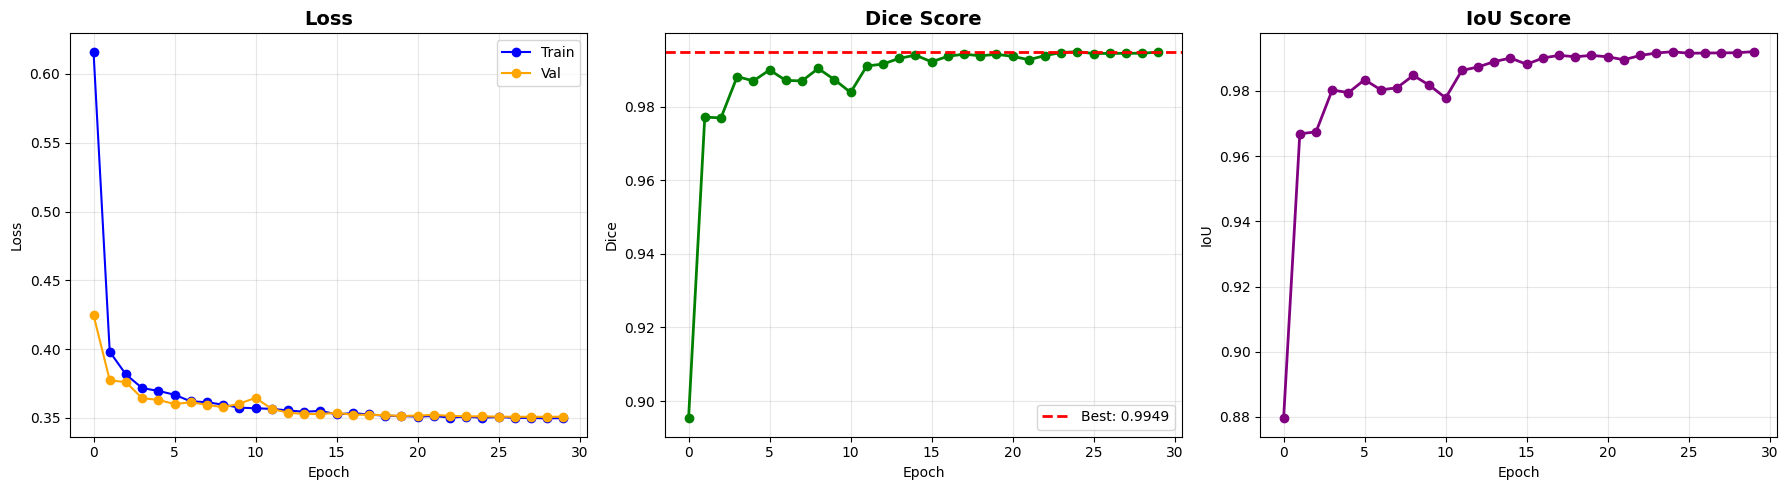


📊 График сохранен: D:\Downloads\Hach_rosn\output\training_history.png


In [13]:
# Графики (без Test)
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(history['train_loss'], 'o-', label='Train', color='blue')
ax[0].plot(history['val_loss'], 'o-', label='Val', color='orange')
ax[0].set_title('Loss', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

ax[1].plot(history['val_dice'], 'o-', color='green', linewidth=2)
ax[1].axhline(trainer.best_dice, color='red', linestyle='--', linewidth=2, 
              label=f'Best: {trainer.best_dice:.4f}')
ax[1].set_title('Dice Score', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Dice')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

ax[2].plot(history['val_iou'], 'o-', color='purple', linewidth=2)
ax[2].set_title('IoU Score', fontsize=14, fontweight='bold')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('IoU')
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 График сохранен: {config.OUTPUT_DIR / 'training_history.png'}")

In [17]:
print("\n" + "="*60)
print("ГОТОВО!")
print("="*60)
print(f"Val Dice:  {trainer.best_dice:.4f}")
print(f"Test Dice: {trainer.test_dice:.4f} ⭐")
print("="*60)


ГОТОВО!
Val Dice:  0.9949


AttributeError: 'Trainer' object has no attribute 'test_dice'